In [52]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import operator
from functools import reduce

import warnings
warnings.filterwarnings('ignore')

# I/O

## to_excel
https://stackoverflow.com/questions/59216329/how-to-export-the-pandas-conditional-formatting-to-an-excel-file

In [2]:
# Initialize example dataframe
np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))], axis=1)
df.iloc[0, 2] = np.nan

def highlight_max(s):
    """Styling function: highlights the maximum in a Series yellow."""
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def color_negative_red(val):
    """Styling function: apply red font color to negative values."""
    color = 'red' if val < 0 else 'black'
    return f'color: {color}'

# Apply conditional formatting to dataframe
styled = df.style.applymap(color_negative_red).apply(highlight_max)\
        .format(formatter={'B':'{:.2%}'})
# styled = df.style.format(formatter={'B':'{:.2%}'})


# Export styled dataframe to excel
styled.to_excel('styled.xlsx', engine='xlsxwriter')
# styled.to_excel('styled.xlsx')
styled

,A,B,C,D,E
0,1,132.92%,nan,-0.31628,-0.99081
1,2,-107.08%,-1.43871,0.564417,0.295722
2,3,-162.64%,0.219565,0.678805,1.88927
3,4,96.15%,0.104011,-0.481165,0.850229
4,5,145.34%,1.05774,0.165562,0.515018
5,6,-133.69%,0.562861,1.39285,-0.063328
6,7,12.17%,1.2076,-0.00204021,1.6278
7,8,35.45%,1.03753,-0.385684,0.519818
8,9,168.66%,-1.32596,1.42898,-2.08935
9,10,-12.98%,0.631523,-0.586538,0.29072


# Plot time-series
1. x-axis use 'string': skip weekends/holidays 
2. x-axis use 'datetime': keep weekends/holidays as gaps

In [3]:
from pandas_datareader import data
# aapl = data.DataReader("AAPL", 
#                        start='2015-1-1', 
#                        end='2015-12-31', 
#                        data_source='yahoo')['Adj Close']
# aapl

#TODO: errors


In [4]:
tickers = ['AAPL', 'SPY', 'VIX']
# ticker = tickers[0]
dat = {ticker: pd.read_csv(Path('./input', f'{ticker}.csv'), index_col=0, parse_dates=True) 
       for ticker in tickers}
retn = {key: val.shift(-1)/val - 1 for key, val in dat.items()}
# retn

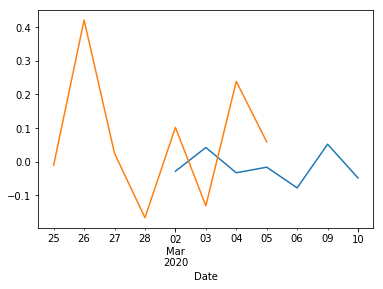

In [5]:
# df.plot: bar plot messes up axis
df0 = retn['SPY'].loc['2020-03-01':'2020-03-10', 'Close']
df1 = retn['VIX'].loc['2020-02-25':'2020-03-05', 'Close']
df2 = retn['AAPL'].loc['2020-02-15':'2020-03-05', 'Close']

fig, ax = plt.subplots()
df0.plot(ax=ax)
df1.plot(ax=ax)
# df2.plot(kind='bar', ax=ax)

In [57]:
# fig, ax = plt.subplots()
# fig.autofmt_xdate()
# xdat =  lambda z: z
# ax.plot(xdat(dat2.index), dat2)
# # ax.xaxis.set_major_locator(ticker.MaxNLocator('auto'))

['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10']
['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05']
DatetimeIndex(['2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05'], dtype='datetime64[ns]', name='Date', freq='D')


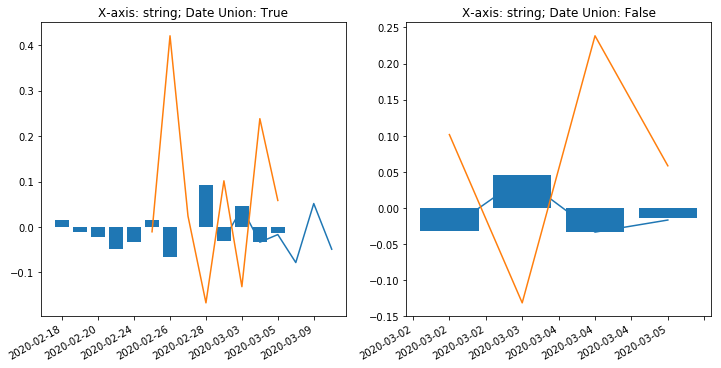

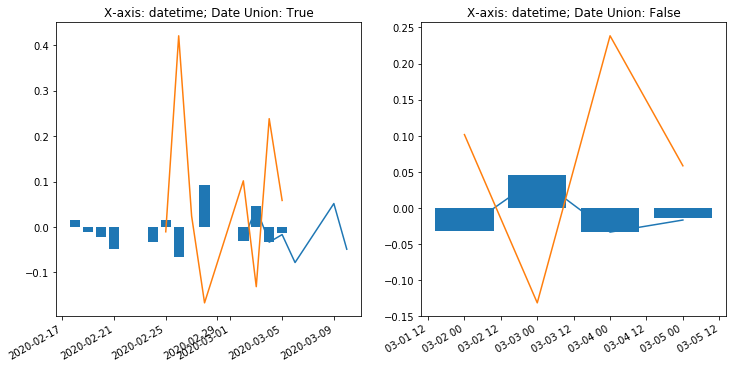

In [68]:
# ax.plot: compare 'string' to 'datetime' for x-axis
# TODO: datetime x-axis has format issues with labelings (bottom 2 charts)
dat0 = retn['SPY'].loc['2020-03-01':'2020-03-10', 'Close']
dat1 = retn['VIX'].loc['2020-02-25':'2020-03-05', 'Close']
dat2 = retn['AAPL'].loc['2020-02-15':'2020-03-05', 'Close']
dats = [dat0, dat1, dat2]

def plot_ts(x_type, date_union, ax):
    if x_type == 'string': 
        ax.xaxis.set_major_locator(ticker.MaxNLocator('auto'))
        xdat = lambda z: [t.strftime('%Y-%m-%d') for t in z]

    elif x_type == 'datetime':       
        xdat =  lambda z: z
        
    # for date union: use or_ and dat0.loc to fill in NaNs to avoid plotting 'wrappinng around'
    time_func = operator.or_ if date_union else operator.and_ 
    dts = reduce(time_func, [dat.index for dat in dats])
    df0, df1, df2 = dat0.loc[dts], dat1.loc[dts], dat2.loc[dts]
    
    print(xdat(df0.index))
    ax.plot(xdat(df0.index), df0)
    ax.plot(xdat(df1.index), df1)
    ax.bar(xdat(df2.index), df2)
    ax.set_title(f'X-axis: {x_type}; Date Union: {date_union}')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.autofmt_xdate()

x_types =  ['string', 'datetime']
# flag_intersect = False
# x_type = x_types[0]
plot_ts(x_types[0], True, axes[0])
plot_ts(x_types[0], False, axes[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.autofmt_xdate()
plot_ts(x_types[1], True, axes[0])
plot_ts(x_types[1], False, axes[1])

# Regular Expressionn

In [7]:
keywords = [' VX1', 'SPX 6M 25D, outright opt', 'VX10', 'VX9', 'SPX 6M 25D delta-hedged forward', 
            'VA2', 'SPX', 'SPX 1M outright', 'SPX 6M delta-hedged cash']
regex = r"VX\d+|6M delta"
regex =r"\b6M\b.*\boutright|\b6M\b.*\bcash\b"
display([re.findall(regex, key) for key in keywords])
display([re.search(regex, key) for key in keywords])

[[], ['6M 25D, outright'], [], [], [], [], [], [], ['6M delta-hedged cash']]

[None,
 <_sre.SRE_Match object; span=(4, 20), match='6M 25D, outright'>,
 None,
 None,
 None,
 None,
 None,
 None,
 <_sre.SRE_Match object; span=(4, 24), match='6M delta-hedged cash'>]

# Logging

In [8]:
dic = df.to_dict()
print(dic)
dic.keys()

{'A': {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 6.0, 6: 7.0, 7: 8.0, 8: 9.0, 9: 10.0}, 'B': {0: 1.3292121726491863, 1: -1.0708162556202396, 2: -1.626404233310685, 3: 0.9615383986783163, 4: 1.4534246664060821, 5: -1.3369356857829062, 6: 0.12166836153455808, 7: 0.35449278572224, 8: 1.6865828874516027, 9: -0.12981993743229778}, 'C': {0: nan, 1: -1.4387132798348028, 2: 0.21956519874807617, 3: 0.10401119568373923, 4: 1.0577374355811098, 5: 0.5628611367075439, 6: 1.2076025381991033, 7: 1.0375276327263334, 8: -1.325963145762744, 9: 0.6315229493643316}, 'D': {0: -0.31628035962142975, 1: 0.5644168515196336, 2: 0.6788047990250634, 3: -0.481165317281003, 4: 0.16556160715827276, 5: 1.39285482506846, 6: -0.0020402149102765046, 7: -0.3856835127679468, 8: 1.4289837002109638, 9: -0.5865380642949874}, 'E': {0: -0.990810386640961, 1: 0.29572188762233814, 2: 1.8892727314152815, 3: 0.8502285312282443, 4: 0.515018378039662, 5: -0.06332798345060607, 6: 1.627795744482153, 7: 0.5198180007843201, 8: -2.08935

dict_keys(['A', 'B', 'C', 'D', 'E'])

In [ ]:
from abc import ABC, abstractmethod

class Vehicle(ABC):
    
    def __init__(self, wheels, seat, engine, steering):
        self._wheels = wheels
        self.sett = seat
        self.engine = engine
        self.steering = steering
    
    @abstractmethod
    def drive(self):
        print('not implemented')
        
    ## C++
    virtual int drive() = 0;
    
class Car(Vehicle):
    
    def drive(self):
        pass
    

In [ ]:
car = Vehicle()
car.

In [ ]:
s = 'My name is Phil'
for c in s[::-1]:
    